In [2]:
# The code was removed by Watson Studio for sharing.

# Coursera Capstone Project

**Jacob Bills**  
Data Systems Engineer

# Objective <a name='objective' />
<p>To determine the best type of business to open based on data among the most popular venues between two of the largest cities in West Virginia</p>

# Background <a name='background' />
<p>Huntington and Charelston WV are the two most populated cities in West Virginia <a href='http://www.togetherweteach.com/TWTIC/uscityinfo/48wv/wvpopr/48wvpr.htm'>(source)</a>. I will use a publicy available list of zip codes in WV to lookup location data using the Google Cloud Platforms Geocoder API. Then I will use Foursquare API to lookup popular venues for each location. I will use this data to evaluate and train multiple clustering models which will help you decide which city is best suited for your business type.</p>
<p>This document is best for someone looking to open a business in Huntington or Charleston WV who has already picked out econimcally viable business locations. I use the location data for these potential business locations to lookup the most popular business types in the area along with the rating for the type of business being opened in those areas to build a recomennder system which determines the city your business is more likely to succeed.
</p>

# In this document
* <a href="#objective">Objective</a>
* <a href="#background">Background</a>
* <a href="#datacollection">Data Collection</a>
  * <a href="#datacollectionzipcode">WV zip code data</a>
  * <a href="#datacollectionlocation">Huntington and Charleston location data</a>
  * <a href="#datacollectionvenue">Huntington and Charleston venue data</a>
* <a href="#datasummary">Summary of Data Collection</a>
  * <a href="#datasummaryviz">Data visualization</a>
  * <a href="#datasummaryhuntington">Most popular Huntington venues</a>
  * <a href="#datasummarycharleston">Most popular Charleston venues</a>
* <a href="#datamodeling">Data Modeling</a>
  * <a href="#datamodelingeval">Model evaluation</a>
  * <a href="#datamodelingsel">Evaluation results</a>
* <a href="#dataround2">Data Collection and Modeling Round 2</a>
  * <a href="#datacol2">Venue detail collection</a>
  * <a href="#datamodel2">Model evaluation and results</a>
* <a href="#conclusion">Conclusion</a>

# Data Collection <a name='datacollection' />

### Get zip code data for West Virginia <a name='datacollectionzipcode' />
<p>I found this <a href='https://www.zipcodestogo.com/West%20Virginia/'>web site</a> after googling for West Virginia zip codes. I transformed the table and dropped the Zip Code Map column, added latitude column, and added longitude column</p>

In [15]:
import pandas as pd
import numpy as np
wvdata = pd.read_html('https://www.zipcodestogo.com/West%20Virginia/')
wvdata[1].iloc[1:].iloc[0]
headers= wvdata[1].iloc[1:].iloc[0]
wvdata = pd.DataFrame(wvdata[1].iloc[2:].values, columns=headers)
wvdata.columns.name =''
wvdata.drop(['Zip Code Map'],axis=1,inplace=True)
wvdata.insert(3,'Latitude',np.nan)
wvdata.insert(4,'Longitude',np.nan)
unique_zipcodes=pd.DataFrame(wvdata['Zip Code'].value_counts())
print("there are ", unique_zipcodes.shape[0], " zipcodes")
wvdata.head(5)

there are  861  zipcodes


,Zip Code,City,County,Latitude,Longitude
0,24701,Bluefield,Mercer,NaN,NaN
1,24712,Athens,Mercer,NaN,NaN
2,24714,Beeson,Mercer,NaN,NaN
3,24715,Bramwell,Mercer,NaN,NaN
4,24716,Bud,Wyoming,NaN,NaN


<p>
For a sandbox tier Foursquare account like mine, <a href='https://foursquare.com/developers/account/billing'>here</a> are the prescribed rate limits for each type of API call against their platform
    
* 950 Regular Calls/Day
* 50 Premium Calls/Day
* 1 Photo per Venue
* 1 Tip per Venue

Since there are 861 unique zip codes I'll limit the result set to the cities of Huntington and Charleston WV, otherwise I will quickly reach the daily limit.
</p>

In [18]:
twocities=wvdata.loc[(wvdata['City'] == 'Huntington') | (wvdata['City'] == 'Charleston')]
print("there are ",twocities.shape[0], " zipcodes among the Huntington and Charelston WV areas.",twocities['Zip Code'].value_counts().shape[0]," of which are unique")

there are  87  zipcodes among the Huntington and Charelston WV areas. 87  of which are unique


<p>So I reduced it down to only 87 zip codes which gives plenty of room before hitting the daily rate limit for the Foursquare API.</p>

### Get location data for the selected zip codes using Google Cloud Platform Geocoder API. <a name='datacollectionlocation' />
*this requires you setup an api key for geocoder api and store it in the google_api_key variable*

<p>For each zip code I used the <a href='https://developers.google.com/maps/documentation/geocoding/'>Google Cloud Platforms Geocoder API</a> to gather the latitude and longitude data. You can find information about the pricing model for this API <a href='https://developers.google.com/maps/documentation/geocoding/usage-and-billing'>here</a>. If you already have a Google Cloud Platform account you can find the exact pricing <a href='https://console.cloud.google.com/apis/library/geocoding-backend.googleapis.com'>here</a>. I will store the location data to the Watson Studio project in order to limit the frequency of calls against this API.
</p>

In [179]:
import requests
for index, row in twocities.iterrows():
    addr=row['City'] + ' WV, ' + row['Zip Code']
    url="https://maps.googleapis.com/maps/api/geocode/json"
    p=[('address',addr), ('key',google_api_key)]
    loc=requests.get(url,params=p).json()['results'][0]['geometry']['location']
    twocities.at[index, 'Latitude'] = loc['lat']
    twocities.at[index, 'Longitude'] = loc['lng']

twocities.head()

,Zip Code,City,County,Latitude,Longitude
259,25301,Charleston,Kanawha,38.351711,-81.633647
260,25302,Charleston,Kanawha,38.388374,-81.598025
261,25303,Charleston,Kanawha,38.363269,-81.685681
262,25304,Charleston,Kanawha,38.279687,-81.614468
263,25305,Charleston,Kanawha,38.337970,-81.610700


*Here is the code that saves the location data results to the Watson Studio project for later retreivel.*

In [29]:
# save raw location data to project
project.save_data(data=twocities.to_csv(index=False),file_name='twocities.csv',overwrite=True)

<p>Some zip codes may have identical longitude,latitude. I perform a group by operation to further limit the result set to only unique longitude,latitude values</p>

In [4]:
import pandas as pd
#load results from gcp api csv file
my_file = project.get_file("twocities.csv")
my_file.seek(0)
df=pd.read_csv(my_file)
df["Zip Code"]= df["Zip Code"].astype(str)
#twocities=df

#without loading results from file
#df=twocities

latlon=df.groupby(['Latitude','Longitude','City','County'])['Zip Code'].agg([('count', 'count'), ('Zip Code', ','.join)]).reset_index()
latlon.sort_values(by=['count'], ascending=False).head(10)

,Latitude,Longitude,City,County,count,Zip Code
13,38.350000,-81.630000,Charleston,Kanawha,22,"25321,25322,25323,25324,25325,25326,25327,2532..."
29,38.420000,-82.440000,Huntington,Cabell,18,"25706,25708,25712,25713,25714,25716,25717,2571..."
27,38.420000,-82.470000,Huntington,Cabell,10,"25770,25771,25772,25773,25774,25775,25776,2577..."
28,38.420000,-82.450000,Huntington,Cabell,5,"25707,25710,25711,25715,25723"
26,38.416135,-81.767764,Charleston,Kanawha,1,25313
21,38.380792,-82.486105,Huntington,Wayne,1,25704
22,38.383407,-81.674729,Charleston,Kanawha,1,25387
23,38.388374,-81.598025,Charleston,Kanawha,1,25302
24,38.409359,-82.361463,Huntington,Cabell,1,25705
25,38.410000,-82.460000,Huntington,Cabell,1,25709


In [9]:
print("there are ", latlon.shape[0], " unique latitude,longitude pairs across the 87 zip codes")

there are  36  unique latitude,longitude pairs across the 87 zip codes


### Get venue recommendations from the Foursquare API using the latitude and longitude data. <a name='datacollectionvenue' />
<p>Geocoder API returned the same location data up to 22 times for different zip codes. This significantly reduces the amount of API calls needed to be performed for gathering venue data from the Foursquare API.</p>
<p><a href='https://developer.foursquare.com/docs/api/venues/explore'>This</a> is the endpoint that I will use for retreiving venue recomendations using the latitude,longitude data. It is not a premium endpoint so I can hit this up to 950 times a day</p>

In [5]:
import requests
LIMIT = 100
radius = 500
def getNearbyVenues(label, names, latitudes, longitudes, city, county, radius=500):
    
    venues_list=[]
    for name, lat, lng, cty, cy in zip(names, latitudes, longitudes, city, county):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            cty,
            cy,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [label, 
                  label + ' Latitude', 
                  label + ' Longitude', 
                  'City',
                  'County',
                  'Venue_ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
dt_venues = getNearbyVenues(label='Zip Code',names=latlon['Zip Code'],
                                   latitudes=latlon['Latitude'],
                                   longitudes=latlon['Longitude'],
                                   city=latlon['City'],county=latlon['County'])

25315
25365
25304
25314
25309
25306
25364
25317
25396
25305
25361
25312
25389
25321,25322,25323,25324,25325,25326,25327,25328,25329,25330,25331,25332,25333,25334,25335,25336,25337,25338,25339,25350,25358,25375
25392
25301
25362
25311
25303
25701
25357
25704
25387
25302
25705
25709
25313
25770,25771,25772,25773,25774,25775,25776,25777,25778,25779
25707,25710,25711,25715,25723
25706,25708,25712,25713,25714,25716,25717,25718,25719,25720,25721,25722,25724,25725,25726,25727,25728,25729
25755
25703
25702
25356
25360
25320


### Analyze and save results of location data

In [16]:
print("there are ", dt_venues.shape[0], " venues in the result set")
dt_venues.head()

there are  474  venues in the result set


,Zip Code,Zip Code Latitude,Zip Code Longitude,City,County,Venue_ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,25364,38.32,-81.58,Charleston,Kanawha,4bf53519370e76b0eda9bd4a,Tudor's Biscuit World,38.318404,-81.578128,Comfort Food Restaurant
1,25364,38.32,-81.58,Charleston,Kanawha,4c715be99375a09305880937,7-Eleven,38.319161,-81.578506,Convenience Store
2,25364,38.32,-81.58,Charleston,Kanawha,4b50fccff964a5201d3c27e3,Drug Emporium,38.317892,-81.575949,Pharmacy
3,25364,38.32,-81.58,Charleston,Kanawha,4c2a3bc0b34ad13a7cf5e7ce,Fifth Third Bank & ATM,38.322248,-81.583617,Bank
4,25364,38.32,-81.58,Charleston,Kanawha,4c57130f12f0d13a524a06ad,Foodland,38.318494,-81.577178,Grocery Store


In [11]:
# save raw location data to project
project.save_data(data=dt_venues.to_csv(index=False),file_name='wv_huntington_charleston_venues.csv',overwrite=True)

{'file_name': 'wv_huntington_charleston_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-enazjz6glyx6ja',
 'asset_id': 'ddfaae23-c283-4e21-9847-9d97451876af'}

In [10]:
import pandas as pd
#load results from venue csv
my_file2 = project.get_file("wv_huntington_charleston_venues.csv")
my_file2.seek(0)
dt_venues=pd.read_csv(my_file2)

#without loading results from file
dt_unique_venues=dt_venues
dt_unique_venues=dt_unique_venues.groupby(['Venue_ID','Venue','Venue Latitude','Venue Longitude','Venue Category','City','County'])['Zip Code'].agg([('count', 'count'), ('Zip Code', ','.join)]).reset_index()
huntington_venues=dt_unique_venues[dt_unique_venues['City']=='Huntington']
charleston_venues=dt_unique_venues[dt_unique_venues['City']=='Charleston']
huntington_venues=huntington_venues.replace(to_replace=r'\'', value="", regex=True)
charleston_venues=charleston_venues.replace(to_replace=r'\'', value="", regex=True)
print("Huntington:",huntington_venues.shape[0],"total venues and",huntington_venues['Venue Category'].value_counts().shape[0], "categories")
print("Charleston:",charleston_venues.shape[0],"total venues and",charleston_venues['Venue Category'].value_counts().shape[0], "categories")
print("Total:",dt_unique_venues.shape[0], "total venues and",dt_unique_venues['Venue Category'].value_counts().shape[0], "categories")

Huntington: 127 total venues and 79 categories
Charleston: 155 total venues and 85 categories
Total: 282 total venues and 123 categories


### Create folium map of venue location data

In [12]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

hlat=(huntington_venues['Venue Latitude'].max()+huntington_venues['Venue Latitude'].min())/2
hlon=(huntington_venues['Venue Longitude'].max()+huntington_venues['Venue Longitude'].min())/2
clat=(charleston_venues['Venue Latitude'].max()+charleston_venues['Venue Latitude'].min())/2
clon=(charleston_venues['Venue Longitude'].max()+charleston_venues['Venue Longitude'].min())/2
map_wv = [
    {'lat':hlat,'lon':hlon,'venues':huntington_venues,'latlon':latlon[latlon['City']=='Huntington'],'map':None,'most_popular':None,'onehot':None,'merged_venues_popular':None,'merged_latlon_popular':None,'clusters':None,'clusters2':None},
    {'lat':clat,'lon':clon,'venues':charleston_venues,'latlon':latlon[latlon['City']=='Charleston'],'map':None,'most_popular':None,'onehot':None,'merged_venues_popular':None,'merged_latlon_popular':None,'clusters':None,'clusters2':None}
]

# add markers to map
for m in map_wv:
    m['map']=folium.Map(location=[m['lat'], m['lon']], zoom_start=12,width='100%')
    for lat, lng, borough, neighborhood in zip(m['venues']['Venue Latitude'], m['venues']['Venue Longitude'], m['venues']['Venue Category'], m['venues']['Venue']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(m['map'])

### Create folium map clustered by most popular venue categories for each zip code. 
*note: I used KMeans with nclusters = 5 purely for visualization purposes. In the Data Modeling section I find the best classification model using this data set which will be used for optimizing prediction results*

In [13]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

kclusters = 5
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for m in map_wv:
    dt_onehot = pd.get_dummies(m['venues'][['Venue Category']], prefix="", prefix_sep="")
    dt_onehot['Zip Code'] = m['venues']['Zip Code'] 
    fixed_columns = [dt_onehot.columns[-1]] + list(dt_onehot.columns[:-1])
    dt_onehot = dt_onehot[fixed_columns]
    m['onehot'] = dt_onehot.groupby('Zip Code').mean().reset_index()

    m['most_popular'] = pd.DataFrame(columns=columns)
    m['most_popular']['Zip Code'] = m['onehot']['Zip Code']
    for ind in np.arange(m['onehot'].shape[0]):
        m['most_popular'].iloc[ind, 1:] = return_most_common_venues(m['onehot'].iloc[ind, :], num_top_venues)
        
    onehot_clustering = m['onehot'].drop('Zip Code', 1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(onehot_clustering)
    mptemp=m['most_popular'].copy(deep=True)
    mptemp.insert(0, 'Cluster Labels', kmeans.labels_)
    
    m['merged_venues_popular'] = m['venues']
    m['merged_venues_popular'] = m['merged_venues_popular'].join(mptemp.set_index('Zip Code'), on='Zip Code')
    m['merged_latlon_popular'] = m['latlon']
    m['merged_latlon_popular'] = m['merged_latlon_popular'].join(mptemp.set_index('Zip Code'), on='Zip Code')
    m['merged_latlon_popular'].dropna(axis=0,inplace=True)
    
    m['clusters'] = folium.Map(location=[m['lat'], m['lon']], zoom_start=12, width='100%')
    m['clusters2'] = folium.Map(location=[m['lat'], m['lon']], zoom_start=12, width='100%')
    
    # add markers to the map
    markers_colors = []
    for lat, lon, cat, cluster in zip(m['merged_venues_popular']['Venue Latitude'], m['merged_venues_popular']['Venue Longitude'], m['merged_venues_popular']['Venue Category'], m['merged_venues_popular']['Cluster Labels']):
        label = folium.Popup('Cluster ' + str(cluster) + ' ' + str(cat), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(m['clusters'])
        
    # add markers to the map
    markers_colors = []
    for lat, lon, z, cluster in zip(m['merged_latlon_popular']['Latitude'], m['merged_latlon_popular']['Longitude'], m['merged_latlon_popular']['Zip Code'], m['merged_latlon_popular']['Cluster Labels']):
        label = folium.Popup('Cluster ' + str(cluster) + ' ' + str(z), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=15,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(m['clusters2'])

# Summary of Data Collection <a name='datasummary' />

### Plot venue locations for the two cities side by side Huntington on the left and Charleston on the right <a name='datasummaryviz' />

In [14]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               .format(map_wv[0]['map'].get_root().render().replace('"', '&quot;'),500,500,
                       map_wv[1]['map'].get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Most popular Huntington venues <a name='datasummaryhuntington' />

In [15]:
map_wv[0]['most_popular'].head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,25703,Fast Food Restaurant,Bar,Mexican Restaurant,Football Stadium,Pizza Place,Rental Car Location,Seafood Restaurant,Gas Station,Automotive Shop,Bank
1,25705,Gas Station,Breakfast Spot,Comfort Food Restaurant,Chinese Restaurant,Grocery Store,Donut Shop,Discount Store,Middle Eastern Restaurant,Mexican Restaurant,Construction & Landscaping
2,"25706,25708,25712,25713,25714,25716,25717,2571...",American Restaurant,Bar,Mexican Restaurant,Italian Restaurant,Mobile Phone Shop,Coffee Shop,Seafood Restaurant,Pub,Bank,Toy / Game Store
3,"25707,25710,25711,25715,25723",Gas Station,Salad Place,BBQ Joint,Donut Shop,Event Space,Fast Food Restaurant,Indian Restaurant,Liquor Store,Motorcycle Shop,Moving Target
4,"25707,25710,25711,25715,25723,25706,25708,2571...",Japanese Restaurant,Asian Restaurant,Gastropub,Pizza Place,Bar,Wings Joint,Design Studio,College Rec Center,Comfort Food Restaurant,Construction & Landscaping


### Display clustering results for Huntington WV

In [16]:
from IPython.core.display import display, HTML

clusterhtmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               .format(map_wv[0]['clusters'].get_root().render().replace('"', '&quot;'),500,500,
                       map_wv[0]['clusters2'].get_root().render().replace('"', '&quot;'),500,500))
display(clusterhtmlmap)

### Most popular Charleston venues <a name='datasummarycharleston' />

In [19]:
map_wv[1]['most_popular'].head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,25301,Clothing Store,Gym / Fitness Center,Kids Store,Doctors Office,Shoe Store,Sporting Goods Shop,Harbor / Marina,Video Game Store,Toy / Game Store,Gourmet Shop
1,25302,Pool,Discount Store,Food Stand,Cosmetics Shop,Department Store,Dessert Shop,Dive Bar,Doctors Office,Farmers Market,Fast Food Restaurant
2,25303,Hotel,Fast Food Restaurant,Food Stand,Cosmetics Shop,Department Store,Dessert Shop,Discount Store,Dive Bar,Doctors Office,Farmers Market
3,"25312,25301",Rock Club,Dive Bar,Yoga Studio,Construction & Landscaping,Cosmetics Shop,Department Store,Dessert Shop,Discount Store,Doctors Office,Farmers Market
4,"25312,25321,25322,25323,25324,25325,25326,2532...",Art Museum,Gym,Gourmet Shop,Seafood Restaurant,Yoga Studio,Fast Food Restaurant,Department Store,Dessert Shop,Discount Store,Dive Bar


### Display clustering results for Charleston WV

In [17]:
from IPython.core.display import display, HTML

clusterhtmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
               .format(map_wv[1]['clusters'].get_root().render().replace('"', '&quot;'),500,500,
                       map_wv[1]['clusters2'].get_root().render().replace('"', '&quot;'),500,500))
display(clusterhtmlmap)

# Data Modeling <a name='datamodeling' />

### To build the recommender system I will combine the venue data for Huntington and Charleston.

<p>
    I will perform onehot encoding on the venue categories, zip codes, and cities to prepare each classification model
</p>

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
huntington_and_charleston_venues=pd.concat([map_wv[0]['venues'],map_wv[1]['venues']])
labelencoder = LabelEncoder()
huntington_and_charleston_venues['category_id']=labelencoder.fit_transform(huntington_and_charleston_venues['Venue Category'])
huntington_and_charleston_venues['city_id']=labelencoder.fit_transform(huntington_and_charleston_venues['City'])
huntington_and_charleston_venues['zipcode_id']=labelencoder.fit_transform(huntington_and_charleston_venues['Zip Code'])
huntington_and_charleston_venues.head()

,Venue_ID,Venue,Venue Latitude,Venue Longitude,Venue Category,City,County,count,Zip Code,category_id,city_id,zipcode_id
5,4b47a4b4f964a520be3826e3,Starbucks,38.422209,-82.443665,Coffee Shop,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",25,1,26
6,4b4899d9f964a520355026e3,Pullman Square,38.422185,-82.443624,Shopping Mall,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",104,1,26
7,4b4b75b4f964a520929c26e3,Fat Pattys,38.425268,-82.423728,Burger Joint,Huntington,Cabell,2,"25755,25703",18,1,31
8,4b4cf5e0f964a5209fc526e3,Red Lobster,38.423513,-82.442233,Seafood Restaurant,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",101,1,26
9,4b4e0995f964a5202bdf26e3,Pita Pit,38.421907,-82.438242,Sandwich Place,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",100,1,26


### Get the most popular venue categories for each zip code in the Huntington and Charleston dataset

In [19]:
import numpy as np
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['zipcode_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# one hot encoding
dt_onehot = pd.get_dummies(huntington_and_charleston_venues[['category_id']].astype(str), prefix="", prefix_sep="")
dt_onehot['zipcode_id'] = huntington_and_charleston_venues['zipcode_id']
huntington_and_charleston_venues_onehot = dt_onehot.groupby('zipcode_id').mean().reset_index()

# create a new dataframe
huntington_and_charleston_venues_mostpopular = pd.DataFrame(columns=columns)
huntington_and_charleston_venues_mostpopular['zipcode_id'] = huntington_and_charleston_venues_onehot['zipcode_id']
for ind in np.arange(huntington_and_charleston_venues_onehot.shape[0]):
    huntington_and_charleston_venues_mostpopular.iloc[ind, 1:] = return_most_common_venues(huntington_and_charleston_venues_onehot.iloc[ind, :], num_top_venues)

huntington_and_charleston_merged = huntington_and_charleston_venues
huntington_and_charleston_merged = huntington_and_charleston_merged.join(huntington_and_charleston_venues_mostpopular.set_index('zipcode_id'), on='zipcode_id')

huntington_and_charleston_merged.head()

,Venue_ID,Venue,Venue Latitude,Venue Longitude,Venue Category,City,County,count,Zip Code,category_id,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,4b47a4b4f964a520be3826e3,Starbucks,38.422209,-82.443665,Coffee Shop,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",25,...,1,66,9,75,116,8,94,101,78,25
6,4b4899d9f964a520355026e3,Pullman Square,38.422185,-82.443624,Shopping Mall,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",104,...,1,66,9,75,116,8,94,101,78,25
7,4b4b75b4f964a520929c26e3,Fat Pattys,38.425268,-82.423728,Burger Joint,Huntington,Cabell,2,"25755,25703",18,...,18,99,15,17,19,2,20,21,22,23
8,4b4cf5e0f964a5209fc526e3,Red Lobster,38.423513,-82.442233,Seafood Restaurant,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",101,...,1,66,9,75,116,8,94,101,78,25
9,4b4e0995f964a5202bdf26e3,Pita Pit,38.421907,-82.438242,Sandwich Place,Huntington,Cabell,1,"25706,25708,25712,25713,25714,25716,25717,2571...",100,...,1,66,9,75,116,8,94,101,78,25


### For each of the following classification models I find the best paramter to yield the highest Jaccard,F1-score, and LogLoss where applicable. <a name='datamodelingeval' />

* KMeans (k = n clusters)
* KNearestNeighbor (knn = k nearest neighbors)
* DecisionTress (k = max_depth)
* SVM (Support Vector Machine 'rbf' and 'linear' kernels)
* Logistic Regression (c)

I partition the data into two sets using the train_test_split method

* 30% used for testing that won't be included in the training set. This should yield better out-of-sample model evalution results
* 70% used for training the model

I use the following features to train the prediction models. 

* Venue Category

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

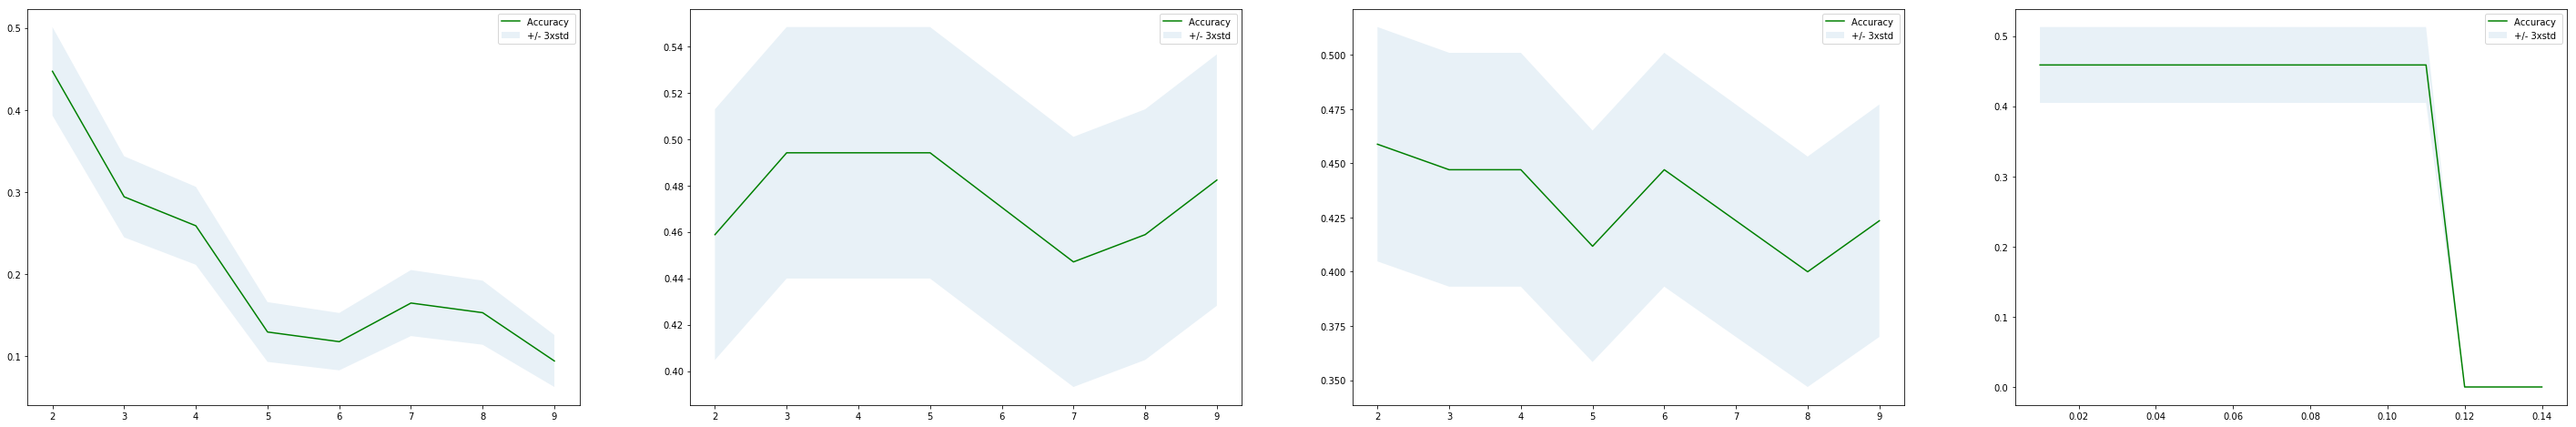

The best accuracy for KMeans 0.4470588235294118 with k= 2
The best accuracy for KNearestNeighbor 0.49411764705882355 with k= 3
The best accuracy for DecisionTree 0.4588235294117647 with k= 2
The best accuracy for LogisticRegression 0.4588235294117647 with C= 0.01
The best accuracy for SVM 0.4588235294117647 with linear kernel


,Jaccard,F1-score,LogLoss
KMeans,0.447059,0.445680,NA
KNN,0.494118,0.492857,NA
Decision Tree,0.458824,0.288615,NA
LogisticRegression,0.458824,0.288615,0.717553
SVM-linear,0.458824,0.288615,NA


In [21]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics

#X=huntington_and_charleston_merged[['category_id','1st Most Common Venue','2nd Most Common Venue']]
X=huntington_and_charleston_merged[['category_id']]
y=huntington_and_charleston_merged['city_id'].values

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

#################################
## FIND BEST VALUES
#################################
Ks = 10
KsMin=2
classifiers=[
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'kmeans','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'kneighbors','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'decisiontree','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'logisticregression','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.nan,'std_acc':np.nan,'label':'svm','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
]

for n in range(KsMin,Ks):
    classifierkm = KMeans(n_clusters=n, random_state=0).fit(X_train,y_train)
    yhat=classifierkm.predict(X_test)
    classifiers[0]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[0]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    classifierknn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=classifierknn.predict(X_test)
    classifiers[1]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[1]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    classifierdt = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=classifierdt.predict(X_test)
    classifiers[2]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[2]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    

#find best LR C
iterations = 15
mean_acc = np.zeros((iterations-1))
std_acc = np.zeros((iterations-1))
ConfustionMx = [];
for n in np.arange(0.01,0.15,0.01):
    LR = LogisticRegression(C=n, solver='liblinear').fit(X_train,y_train)
    yhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)
    mean_acc[(int)(((n*iterations*10)-1)/2)] = metrics.accuracy_score(y_test, yhat)
    std_acc[(int)(((n*iterations*10)-1)/2)]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


#find best SVM kernel
kernels=[
    {'kernel':'rbf','f1score':np.nan,'jaccard':np.nan},
    {'kernel':'linear','f1score':np.nan,'jaccard':np.nan},
]
for kern in kernels:
    svmc=svm.SVC(kernel=kern['kernel']).fit(X_train,y_train)
    yhat=svmc.predict(X_test)
    kern['f1score']=f1_score(y_test, yhat, average='weighted') 
    kern['jaccard']=jaccard_similarity_score(y_test, yhat)
    
svm_kern=np.nan
svm_avg=0
for kern in kernels:
    avg=(kern['f1score']+kern['jaccard'])/2
    if (avg > svm_avg):
        svm_age = avg
        svm_kern=kern

kmeans_best=classifiers[0]['mean_acc'].argmax()+KsMin
knn_best=classifiers[1]['mean_acc'].argmax()+KsMin
dtree_best=classifiers[2]['mean_acc'].argmax()+KsMin
lr_best=(mean_acc.argmax()+1)*0.01

classifierkm = KMeans(n_clusters=kmeans_best, random_state=0).fit(X_train,y_train)
yhat=classifierkm.predict(X_test)
classifiers[0]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[0]['jaccard']=jaccard_similarity_score(y_test, yhat)    

classifierknn = KNeighborsClassifier(n_neighbors = knn_best).fit(X_train,y_train)
yhat=classifierknn.predict(X_test)
classifiers[1]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[1]['jaccard']=jaccard_similarity_score(y_test, yhat)

classifierdt = DecisionTreeClassifier(criterion="entropy", max_depth = dtree_best).fit(X_train,y_train)
yhat=classifierdt.predict(X_test)
classifiers[2]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[2]['jaccard']=jaccard_similarity_score(y_test, yhat)

LR = LogisticRegression(C=lr_best, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
classifiers[3]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[3]['jaccard']=jaccard_similarity_score(y_test, yhat)
classifiers[3]['logloss']=log_loss(y_test, yhat_prob)


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
axes[0].plot(range(KsMin,Ks),classifiers[0]['mean_acc'],'g')
axes[0].fill_between(range(KsMin,Ks),classifiers[0]['mean_acc'] - 1 * classifiers[0]['std_acc'],classifiers[0]['mean_acc'] + 1 * classifiers[0]['std_acc'], alpha=0.10)
axes[0].legend(('Accuracy ', '+/- 3xstd'))

axes[1].plot(range(KsMin,Ks),classifiers[1]['mean_acc'],'g')
axes[1].fill_between(range(KsMin,Ks),classifiers[1]['mean_acc'] - 1 * classifiers[1]['std_acc'],classifiers[1]['mean_acc'] + 1 * classifiers[1]['std_acc'], alpha=0.10)
axes[1].legend(('Accuracy ', '+/- 3xstd'))

axes[2].plot(range(KsMin,Ks),classifiers[2]['mean_acc'],'g')
axes[2].fill_between(range(KsMin,Ks),classifiers[2]['mean_acc'] - 1 * classifiers[2]['std_acc'],classifiers[2]['mean_acc'] + 1 * classifiers[2]['std_acc'], alpha=0.10)
axes[2].legend(('Accuracy ', '+/- 3xstd'))

axes[3].plot(np.arange(0.01,0.15,0.01),mean_acc,'g')
axes[3].fill_between(np.arange(0.01,0.15,0.01),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
axes[3].legend(('Accuracy ', '+/- 3xstd'))
#axes[3].xticks(np.arange(0.01,0.15,0.0))

plt.show()
print("The best accuracy for KMeans", classifiers[0]['mean_acc'].max(), "with k=", classifiers[0]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for KNearestNeighbor", classifiers[1]['mean_acc'].max(), "with k=", classifiers[1]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for DecisionTree", classifiers[2]['mean_acc'].max(), "with k=", classifiers[2]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for LogisticRegression", mean_acc.max(), "with C=", (mean_acc.argmax()+1)*0.01)
print("The best accuracy for SVM", max(svm_kern['f1score'],svm_kern['jaccard']) ,"with",svm_kern['kernel'],"kernel")
d = {
     'Jaccard': [classifiers[0]['jaccard'], classifiers[1]['jaccard'],classifiers[2]['jaccard'],classifiers[3]['jaccard'],svm_kern['jaccard']],
     'F1-score': [classifiers[0]['f1score'],classifiers[1]['f1score'],classifiers[2]['f1score'],classifiers[3]['f1score'],svm_kern['f1score']],
     'LogLoss': [None,None,None,classifiers[3]['logloss'],None]}
report = pd.DataFrame(data=d,index=['KMeans','KNN', 'Decision Tree', 'LogisticRegression', 'SVM-'+svm_kern['kernel']])
report.replace(np.nan, "NA", inplace = True)
report

### KNearestNeighbor is the best model with an accuracy of 49% when n neighbors of 3. Here I get a distribution of the amount of times it recommended Huntington vs recommending Charleston <a name='datamodelingsel' />

In [22]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
#X2=huntington_and_charleston_merged[['category_id','1st Most Common Venue']]
X2=huntington_and_charleston_merged[['category_id']]
y2=huntington_and_charleston_merged['city_id'].values
classifier = KNeighborsClassifier(n_neighbors = 3).fit(X_train,y_train)
#classifier = DecisionTreeClassifier(criterion="entropy", max_depth = 5).fit(X_train,y_train)
ar=[]
#for idx,row in huntington_and_charleston_merged[['category_id','1st Most Common Venue']].iterrows():
for idx,row in huntington_and_charleston_merged[['category_id']].iterrows():
#    p=classifier.predict([row[['category_id','1st Most Common Venue']]])[0]
    p=classifier.predict([[row['category_id']]])[0]
    ar.append(p)

unique,counts=np.unique(ar, return_counts=True)
dict(zip(unique, counts))
report

,Jaccard,F1-score,LogLoss
KMeans,0.447059,0.445680,NA
KNN,0.494118,0.492857,NA
Decision Tree,0.458824,0.288615,NA
LogisticRegression,0.458824,0.288615,0.717553
SVM-linear,0.458824,0.288615,NA


# Data Collection and Modeling Round 2 <a name='dataround2'>
Given that the best we can acheieve with solely the category_id in feature set is ~50% accurate (coin flip), I will gather venue details here and store the results for later retrieval

In [23]:
import requests
def getVenueDetails(vids):
    
    venues_list=[]
    for vid in zip(vids):
        print("getting",vid[0],"venue details")
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            vid[0],
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)
            
        # make the GET request
        json=requests.get(url).json()
        result = json["response"]
        if json['meta']['code'] == 200:
            rating=np.nan
            likes=np.nan
            checkins=np.nan
            users=np.nan
            tips=np.nan
            visits=np.nan
    
            if 'rating' in result['venue']:
                rating = result['venue']['rating']
        
            if 'likes' in result['venue']:
                if 'count' in result['venue']['likes']:
                    likes = result['venue']['likes']['count']
        
            if 'stats' in result['venue']:
                if 'checkinsCount' in result['venue']['stats']:
                    checkins = result['venue']['stats']['checkinsCount']
                if 'usersCount' in result['venue']['stats']:
                    users = result['venue']['stats']['usersCount']
                if 'tipCount' in result['venue']['stats']:
                    tips = result['venue']['stats']['tipCount']
                if 'visitsCount' in result['venue']['stats']:
                    visits = result['venue']['stats']['visitsCount']
    
            venues_list.append([(
                result['venue']['id'],
                result['venue']['name'], 
                rating,
                likes,
                checkins, 
                users,  
                tips,
                visits)])

    if venues_list != []:
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Venue_ID', 'Venue','Rating','Likes','Checkins','Users','Tips','Visits']
        return(nearby_venues)
    else:
        return None

### Calling a premium endpoint to get venue details like rating, likes, checkins, users, tips, visists <a name='datacol2' />

In [55]:
venue_details = getVenueDetails(vids=huntington_and_charleston_venues['Venue_ID'])
#venue_detail = getVenueDetail('4b4fce3ff964a5200f1627e3')

getting 4b47a4b4f964a520be3826e3 venue details
getting 4b4899d9f964a520355026e3 venue details
getting 4b4b75b4f964a520929c26e3 venue details
getting 4b4cf5e0f964a5209fc526e3 venue details
getting 4b4e0995f964a5202bdf26e3 venue details
getting 4b4e1011f964a5202ae026e3 venue details
getting 4b4fce3ff964a5200f1627e3 venue details
getting 4b50a0f4f964a5202d2a27e3 venue details
getting 4b521e3ff964a520566927e3 venue details
getting 4b526559f964a520387b27e3 venue details
getting 4b539661f964a5208ca327e3 venue details
getting 4b55e9aaf964a52014f627e3 venue details
getting 4b55ebe6f964a52094f627e3 venue details
getting 4b565304f964a520520b28e3 venue details
getting 4b5743aff964a520262e28e3 venue details
getting 4b574da0f964a5204c3028e3 venue details
getting 4b578edcf964a5208f3828e3 venue details
getting 4b59bcf8f964a5206e9528e3 venue details
getting 4b5a3c3cf964a52070b628e3 venue details
getting 4b5a9f3cf964a5202fce28e3 venue details
getting 4b5b573ef964a520f5f528e3 venue details
getting 4b5bd

In [57]:
venue_details.head()

,Venue_ID,Venue,Rating,Likes,Checkins,Users,Tips,Visits
0,4b47a4b4f964a520be3826e3,Starbucks,8.2,74,NaN,NaN,24,NaN
1,4b4899d9f964a520355026e3,Pullman Square,8.7,51,NaN,NaN,4,NaN
2,4b4b75b4f964a520929c26e3,Fat Patty's,8.6,79,NaN,NaN,36,NaN
3,4b4cf5e0f964a5209fc526e3,Red Lobster,8.6,42,NaN,NaN,14,NaN
4,4b4e0995f964a5202bdf26e3,Pita Pit,8.3,13,NaN,NaN,7,NaN


In [58]:
# save raw location data to project
project.save_data(data=venue_details.to_csv(index=False),file_name='venuedetails.csv',overwrite=True)

{'file_name': 'venuedetails.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-enazjz6glyx6ja',
 'asset_id': 'df7717ac-c2ce-4e50-8588-ed3c5bde3aad'}

In [24]:
my_file3 = project.get_file("venuedetails.csv")
my_file3.seek(0)
venue_details=pd.read_csv(my_file3)
#df["Zip Code"]= df["Zip Code"].astype(str)

#
dd=huntington_and_charleston_merged
dd=dd.join(venue_details.set_index('Venue_ID'),on='Venue_ID',how='left',lsuffix='_left', rsuffix='_right')
dd=dd[['Venue_ID','Venue_left','Rating','Likes','Tips','city_id','category_id','1st Most Common Venue']]
dd.dropna(axis=0,inplace=True)
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(dd[['Rating','Likes','Tips']])
#dd[['Rating','Likes','Tips']]=x_scaled

In [25]:
print("There are ",dd['Venue_ID'].value_counts().shape[0],"venues with extra details")
dd.head()

There are  220 venues with extra details


,Venue_ID,Venue_left,Rating,Likes,Tips,city_id,category_id,1st Most Common Venue
5,4b47a4b4f964a520be3826e3,Starbucks,8.2,74,24,1,25,1
6,4b4899d9f964a520355026e3,Pullman Square,8.7,51,4,1,104,1
7,4b4b75b4f964a520929c26e3,Fat Pattys,8.6,79,36,1,18,18
8,4b4cf5e0f964a5209fc526e3,Red Lobster,8.6,42,14,1,101,1
9,4b4e0995f964a5202bdf26e3,Pita Pit,8.3,13,7,1,100,1


### I run several model evaluations again using category_id,1st Most Common Venue,Rating as features of predicting the correct city<a name='datamodel2' />

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


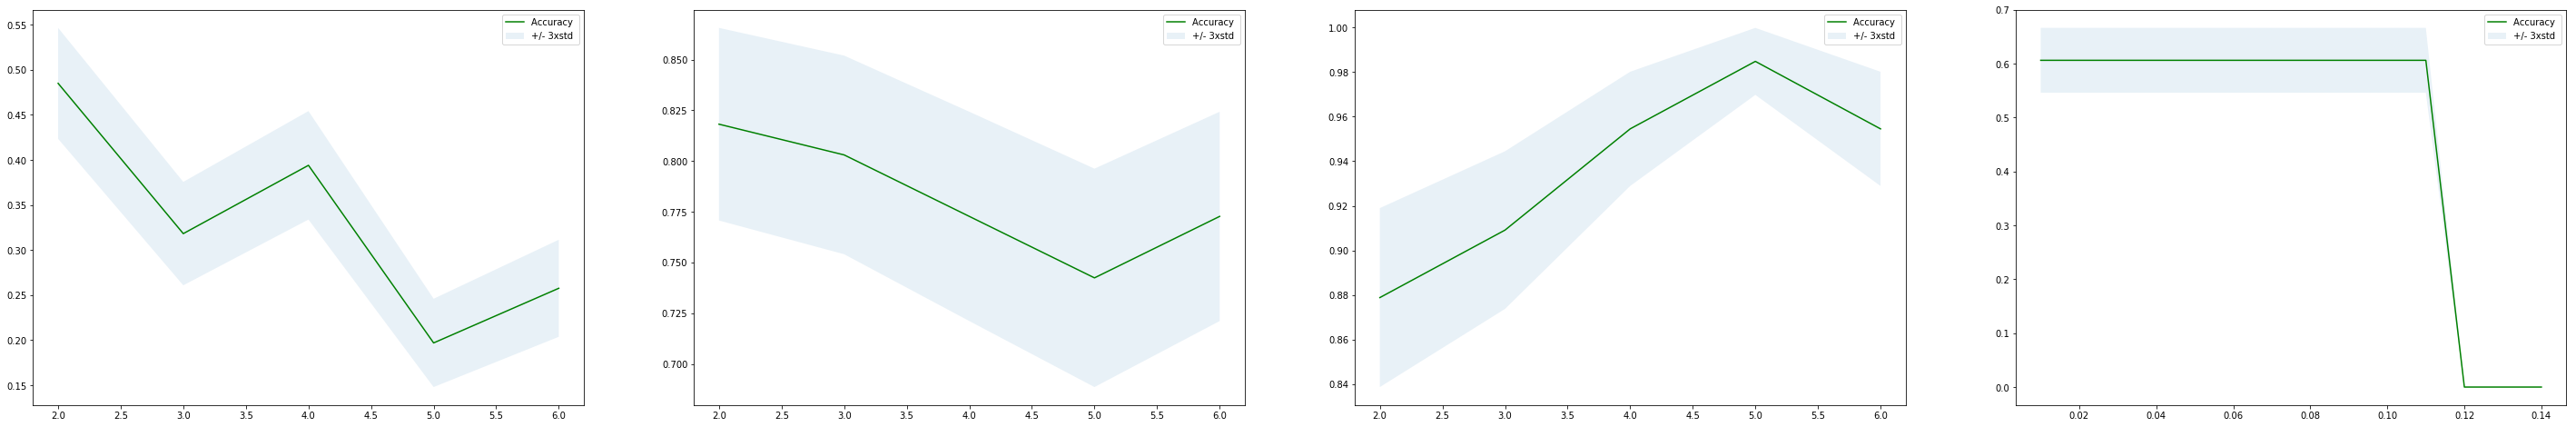

The best accuracy for KMeans 0.48484848484848486 with k= 2
The best accuracy for KNearestNeighbor 0.8181818181818182 with k= 2
The best accuracy for DecisionTree 0.9848484848484849 with k= 5
The best accuracy for LogisticRegression 0.6060606060606061 with C= 0.01
The best accuracy for SVM 0.6060606060606061 with linear kernel


,Jaccard,F1-score,LogLoss
KMeans,0.484848,0.490572,NA
KNN,0.818182,0.809917,NA
Decision Tree,0.984848,0.984896,NA
LogisticRegression,0.606061,0.457404,0.672433
SVM-linear,0.606061,0.457404,NA


In [28]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics

X=dd[['category_id','1st Most Common Venue','Rating']]
y=dd['city_id'].values

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

#################################
## FIND BEST VALUES
#################################
Ks = 7
KsMin=2
classifiers=[
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'kmeans','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'kneighbors','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'decisiontree','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.zeros((Ks-KsMin)),'std_acc':np.zeros((Ks-KsMin)),'label':'logisticregression','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
    {'mean_acc':np.nan,'std_acc':np.nan,'label':'svm','f1score':np.nan,'jaccard':np.nan,'logloss':np.nan},
]

for n in range(KsMin,Ks):
    classifierkm = KMeans(n_clusters=n, random_state=0).fit(X_train,y_train)
    yhat=classifierkm.predict(X_test)
    classifiers[0]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[0]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    classifierknn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=classifierknn.predict(X_test)
    classifiers[1]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[1]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    classifierdt = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=classifierdt.predict(X_test)
    classifiers[2]['mean_acc'][n-KsMin] = metrics.accuracy_score(y_test, yhat)
    classifiers[2]['std_acc'][n-KsMin]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    

#find best LR C
iterations = 15
mean_acc = np.zeros((iterations-1))
std_acc = np.zeros((iterations-1))
ConfustionMx = [];
for n in np.arange(0.01,0.15,0.01):
    LR = LogisticRegression(C=n, solver='liblinear').fit(X_train,y_train)
    yhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)
    mean_acc[(int)(((n*iterations*10)-1)/2)] = metrics.accuracy_score(y_test, yhat)
    std_acc[(int)(((n*iterations*10)-1)/2)]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


#find best SVM kernel
kernels=[
    {'kernel':'rbf','f1score':np.nan,'jaccard':np.nan},
    {'kernel':'linear','f1score':np.nan,'jaccard':np.nan},
]
for kern in kernels:
    svmc=svm.SVC(kernel=kern['kernel']).fit(X_train,y_train)
    yhat=svmc.predict(X_test)
    kern['f1score']=f1_score(y_test, yhat, average='weighted') 
    kern['jaccard']=jaccard_similarity_score(y_test, yhat)
    
svm_kern=np.nan
svm_avg=0
for kern in kernels:
    avg=(kern['f1score']+kern['jaccard'])/2
    if (avg > svm_avg):
        svm_age = avg
        svm_kern=kern

#################################
## GET F1 SCORE AND JACCARD INDEX
#################################
kmeans_best=classifiers[0]['mean_acc'].argmax()+KsMin
knn_best=classifiers[1]['mean_acc'].argmax()+KsMin
dtree_best=classifiers[2]['mean_acc'].argmax()+KsMin
lr_best=(mean_acc.argmax()+1)*0.01

classifierkm = KMeans(n_clusters=kmeans_best, random_state=0).fit(X_train,y_train)
yhat=classifierkm.predict(X_test)
classifiers[0]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[0]['jaccard']=jaccard_similarity_score(y_test, yhat)    

classifierknn = KNeighborsClassifier(n_neighbors = knn_best).fit(X_train,y_train)
yhat=classifierknn.predict(X_test)
classifiers[1]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[1]['jaccard']=jaccard_similarity_score(y_test, yhat)

classifierdt = DecisionTreeClassifier(criterion="entropy", max_depth = dtree_best).fit(X_train,y_train)
yhat=classifierdt.predict(X_test)
classifiers[2]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[2]['jaccard']=jaccard_similarity_score(y_test, yhat)

LR = LogisticRegression(C=lr_best, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
classifiers[3]['f1score']=f1_score(y_test, yhat, average='weighted') 
classifiers[3]['jaccard']=jaccard_similarity_score(y_test, yhat)
classifiers[3]['logloss']=log_loss(y_test, yhat_prob)


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
axes[0].plot(range(KsMin,Ks),classifiers[0]['mean_acc'],'g')
axes[0].fill_between(range(KsMin,Ks),classifiers[0]['mean_acc'] - 1 * classifiers[0]['std_acc'],classifiers[0]['mean_acc'] + 1 * classifiers[0]['std_acc'], alpha=0.10)
axes[0].legend(('Accuracy ', '+/- 3xstd'))

axes[1].plot(range(KsMin,Ks),classifiers[1]['mean_acc'],'g')
axes[1].fill_between(range(KsMin,Ks),classifiers[1]['mean_acc'] - 1 * classifiers[1]['std_acc'],classifiers[1]['mean_acc'] + 1 * classifiers[1]['std_acc'], alpha=0.10)
axes[1].legend(('Accuracy ', '+/- 3xstd'))

axes[2].plot(range(KsMin,Ks),classifiers[2]['mean_acc'],'g')
axes[2].fill_between(range(KsMin,Ks),classifiers[2]['mean_acc'] - 1 * classifiers[2]['std_acc'],classifiers[2]['mean_acc'] + 1 * classifiers[2]['std_acc'], alpha=0.10)
axes[2].legend(('Accuracy ', '+/- 3xstd'))

axes[3].plot(np.arange(0.01,0.15,0.01),mean_acc,'g')
axes[3].fill_between(np.arange(0.01,0.15,0.01),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
axes[3].legend(('Accuracy ', '+/- 3xstd'))
#axes[3].xticks(np.arange(0.01,0.15,0.0))

plt.show()
print("The best accuracy for KMeans", classifiers[0]['mean_acc'].max(), "with k=", classifiers[0]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for KNearestNeighbor", classifiers[1]['mean_acc'].max(), "with k=", classifiers[1]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for DecisionTree", classifiers[2]['mean_acc'].max(), "with k=", classifiers[2]['mean_acc'].argmax()+KsMin) 
print("The best accuracy for LogisticRegression", mean_acc.max(), "with C=", (mean_acc.argmax()+1)*0.01)
print("The best accuracy for SVM", max(svm_kern['f1score'],svm_kern['jaccard']) ,"with",svm_kern['kernel'],"kernel")

#################################
## CREATE REPORT
#################################
d = {
     'Jaccard': [classifiers[0]['jaccard'], classifiers[1]['jaccard'],classifiers[2]['jaccard'],classifiers[3]['jaccard'],svm_kern['jaccard']],
     'F1-score': [classifiers[0]['f1score'],classifiers[1]['f1score'],classifiers[2]['f1score'],classifiers[3]['f1score'],svm_kern['f1score']],
     'LogLoss': [None,None,None,classifiers[3]['logloss'],None]}
report = pd.DataFrame(data=d,index=['KMeans','KNN', 'Decision Tree', 'LogisticRegression', 'SVM-'+svm_kern['kernel']])
report.replace(np.nan, "NA", inplace = True)
report

### DecisionTreeClassifer predicts the city correclty 98% of the time given the features category_id,1st Most Common Venue,Rating <a name='datamodeleval2' />

In [29]:
report

,Jaccard,F1-score,LogLoss
KMeans,0.484848,0.490572,NA
KNN,0.818182,0.809917,NA
Decision Tree,0.984848,0.984896,NA
LogisticRegression,0.606061,0.457404,0.672433
SVM-linear,0.606061,0.457404,NA


# Conclusion <a name='conclusion'>



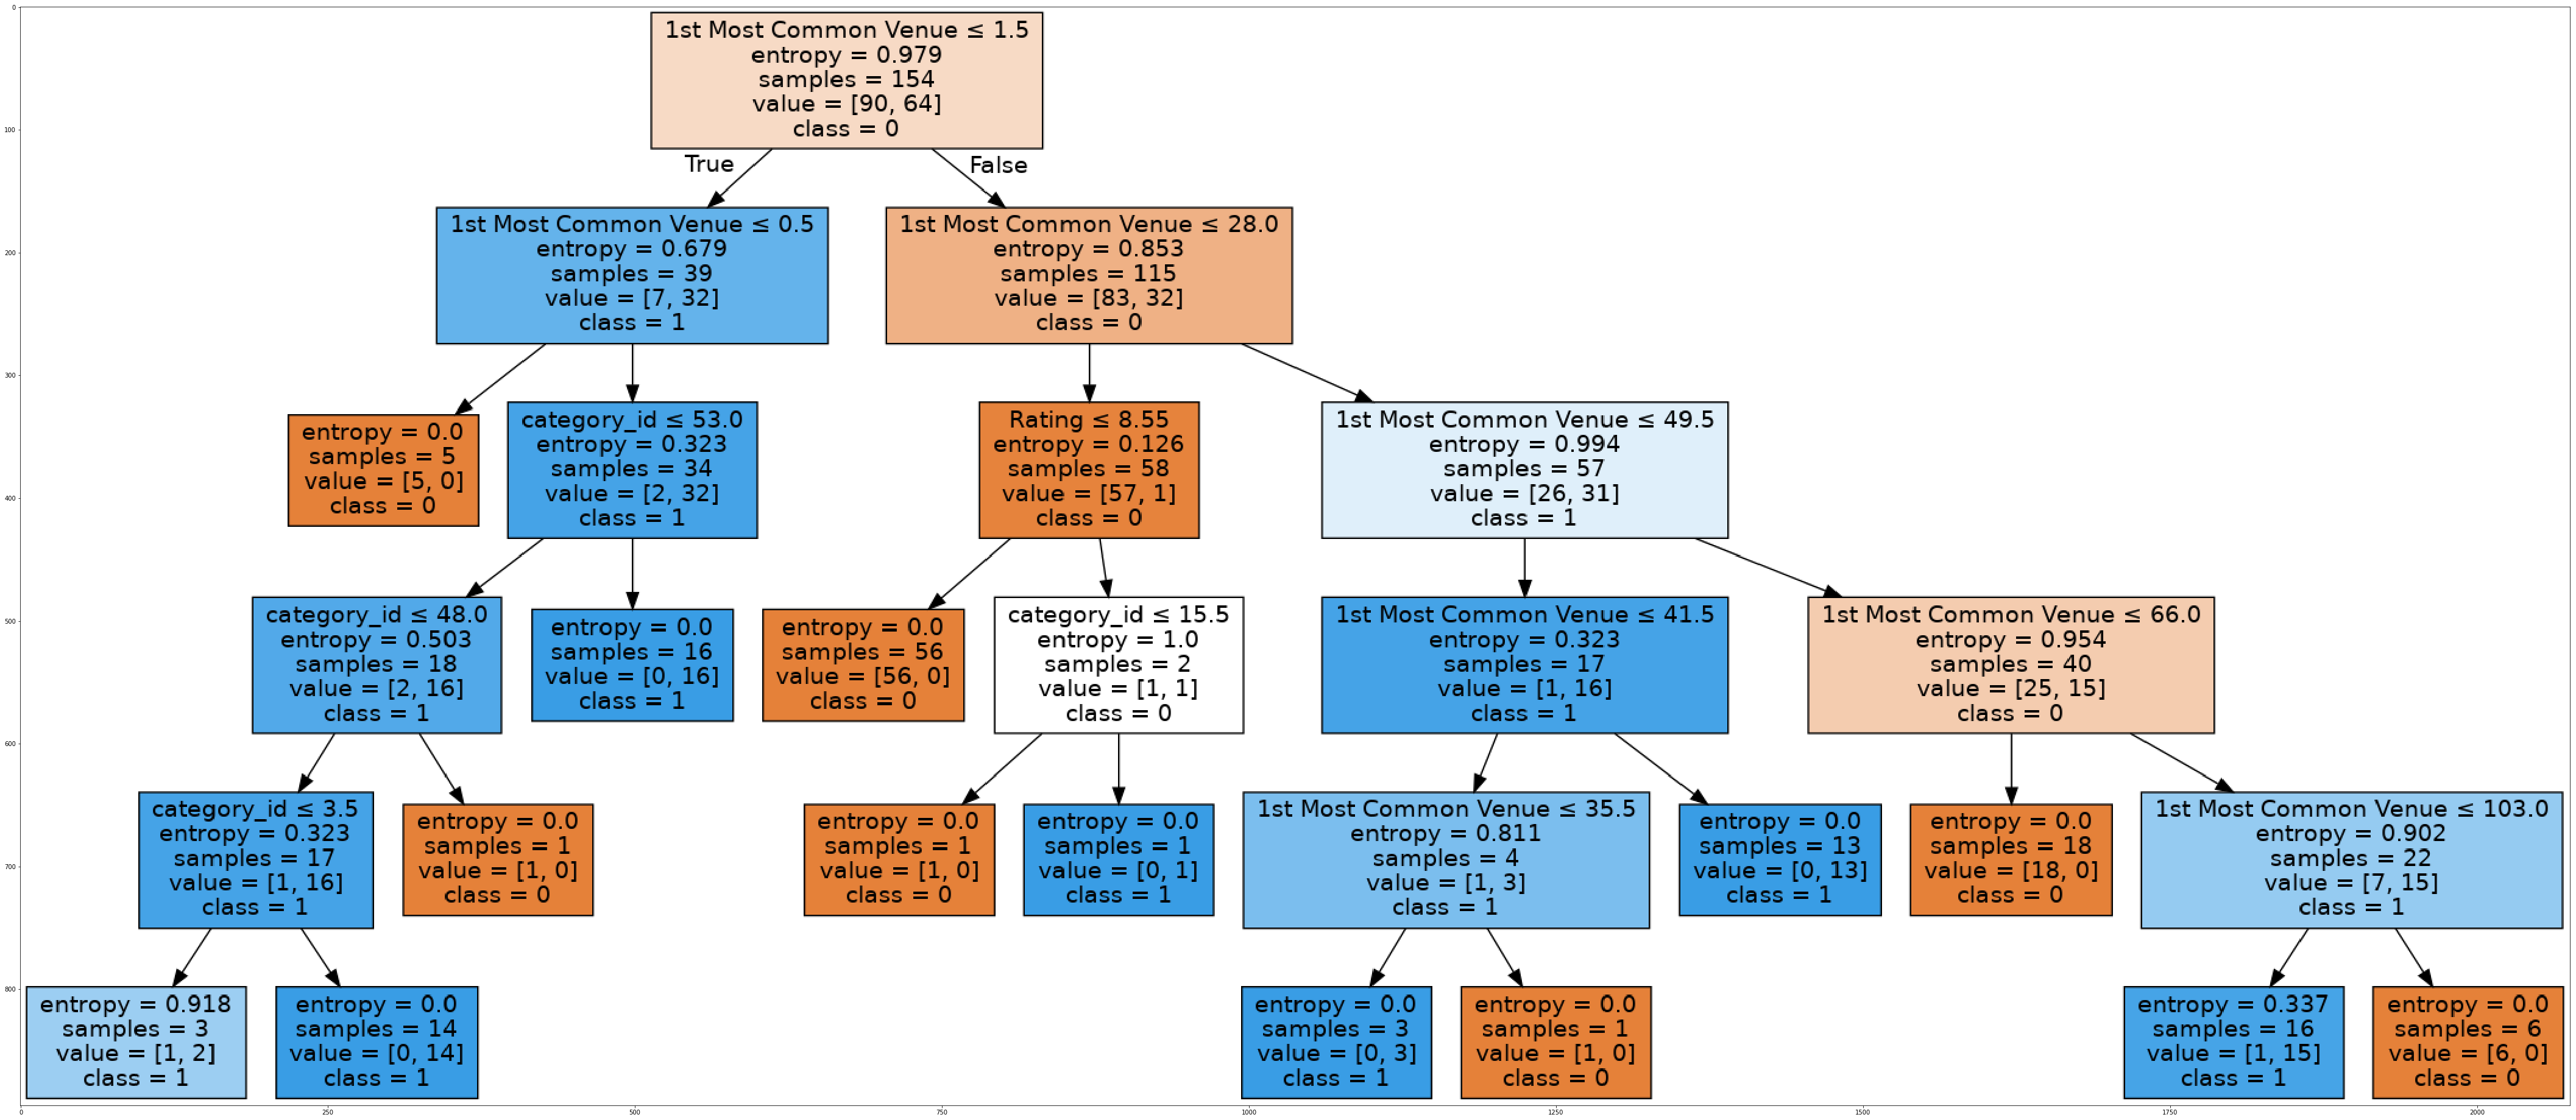

In [62]:
#!conda install -c conda-forge pydotplus --yes
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
dot_data = StringIO()
filename = "dtree.png"
targetNames = dd['city_id'].astype(str).unique().tolist()
out=tree.export_graphviz(classifierdt,feature_names=['category_id','1st Most Common Venue','Rating'], out_file=dot_data, class_names= np.unique(y_train.astype(str)), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(75,75))
plt.imshow(img,interpolation='nearest')